# Introduction

With the rise in Big Data jobs in recent years, many different positions with specialized duties and disparate skillsets have become much more common. Furthermore, companies will also seek out interns to train and later employ, whose positions may require different skillsets than their full-time counterparts. In order to learn more about the distinct skills that these job listings are asking for, we decided to scrape job sites to see which skills are currently in demand. The job board and aggregator Indeed has its own webcrawler, which scrapes other companies’ websites and formats these jobs to host on its own website. This job site became the ideal target for our project, and we scraped this data continuously to avoid any temporal bias in the data; job listings will disappear from Indeed after some time, especially if they are easier to fill or receive more applications, so recording a snapshot of the search results would be insufficient (a snapshot would be more likely to capture older, less desirable or easily-filled jobs). 

To avoid this bias in our project, we collected the most recent Indeed data for over a month, starting from mid-April. We performed this analysis for six queries in total: “data analyst”, “data science”, and “machine learning”, and their corresponding intern positions as well. The file `AllScrapes.py` contains the class (`IndeedScraper`) and method (`scrape_all`) used to obtain the data used in this analysis; it scrapes a page of search results on Indeed to get the individual job keys, and then scrapes those individual job keys to get job-specific data; e.g. job title, time posted, and (most importantly) the full job description text. The class and method are called from the file `module-usage.py`; the results are stored in three separate files, and we combine these three files into one .tsv with `tsv-combiner-final.py`. 

In this notebook file, we parse the data from the combined .tsv, and concurrently upload it to a SQLite database file. Only the lines that are easy to parse are added, which amount to ~24,000 jobs total. Then, we `SELECT` the number of jobs from the dataset whose descriptions contain specific skills. We perform a chi-square test on the proportions of these jobs that require each of the skills, and the resulting chi-square statistics (one for each skill, across all queries) are printed out. 

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import pandas as pd
from sqlalchemy import *
import sqlalchemy as sqla
from sqlalchemy import inspect
import timeit
import time
import plotnine as p9
import numpy as np
%matplotlib inline


fullfile = "../data/test.tsv"

# SQLite Setup

We started by creating our sqlite file, as well as creating a connection to the engine to access sqlite tables.

In [3]:
#### Clean & Upload to SQLite database
## First, create the file
sqlite_file = '../data/cleaned.sqlite'
cnx = sqla.create_engine('sqlite:///' + sqlite_file)
insp = inspect(cnx)

In [4]:
### shows what tables are in the engine
#print(insp.get_table_names())

In [5]:
# Check if engine has clean_jobs table (has_table is deprecated?)
# check=insp.has_table('clean_jobs')
# check

In [6]:
## DONT RUN IF YOU WANT TO KEEP GOING
#drop table if it already exist
#try:
#    clean_jobs.drop(cnx)
#    print('dropped table')
#except:
#    print("did not drop table")


We initialized an empty table in SQLite, if it does not exist.

In [7]:
metadata = MetaData()
clean_jobs = Table('clean_jobs', metadata,
        Column('Key', String(16), nullable=False),
        Column('Title', String, nullable=False),
        Column('Recency', String),
        Column('Time_Scraped', String, nullable=False),
        Column('Company_Details', String, nullable=False),
        Column('Query', String, nullable=False),
        Column('Description', String, nullable=False)
    )
try:
    clean_jobs.create(cnx)
    print("created clean_jobs table because it didnt exist")
except:
    print("clean_jobs table already exist")

created clean_jobs table because it didnt exist


Now we can see that the `clean_jobs` table exists.

In [8]:
# Check if engine has clean_jobs table 
# check=insp.has_table('clean_jobs')
# check
print(insp.get_table_names())

['clean_jobs']


# Upload data to SQLite D.B.

We created a function called `append_line_to_sql()` that cleans our scraped .tsv entries and appends the cleaned results into the sql database.

In [9]:
def append_line_to_sql(splitted):
    """
    Takes a line from a .tsv that has already been splitted on '\t', and uploads it 
    to a SQLite database. 
    First, it checks if the line has 7 elements; junk reads often 
    consist of only one element, and do not have 7 values. Next, it looks for the words
    "Job Description" and "Report job", both of which would have showed up if the entire 
    page's text was scraped correctly. The details are turned into a dictionary and 
    then a dataframe, which is uploaded to the SQLite file. A boolean is returned for 
    debugging/progress-tracking purposes.
    
    (Some jobs on Indeed will not have the words "Job Description", making it difficult 
    to trim the job descriptions and decrease the size of the data. Furthermore, Indeed 
    will (rarely) host another company website's job listing directly, instead of 
    scraping the listing, and Indeed-scraping methods will fail to return any results; 
    because the job description will be empty, this is also avoided by checking for "Job 
    Description" and "Report job".)
    """
    if(len(splitted)==7):
        tempT = splitted[6]
        tempI1 = tempT.find("Job Description")
        tempI2 = tempT.find("Report job")
        if(tempI1!=-1 and tempI2 !=-1):
            cleanedDesc = tempT[tempI1+16:tempI2]
            tempdf = pd.DataFrame({"Key":[splitted[0]], 
                        "Title":[splitted[1]], 
                        "Recency":[splitted[2]], 
                        "Time_Scraped":[splitted[3]], 
                        "Company_Details":[splitted[4]], 
                        "Query":[splitted[5]], 
                        "Description":[cleanedDesc]})
            tempdf.to_sql('clean_jobs',cnx,if_exists='append',index=False)
            return True
    return False

Next, we uploaded our data in the SQLite Database into the `clean_jobs` table we initialized earlier, displaying the time needed to process every 5000 entries, and eventually the total number of rows in our database.

In [10]:
## Upload valid .tsv entries to SQLite database
# takes ~5-10 mins.
# np.vectorize will be ineffective here, as it only emulates a for() loop; there is no further optimization
counter = 0
temp = False
starttime = time.time()
with open(fullfile, encoding="utf-8") as file1:
    aline = file1.readline()  # skip column names

    for line in file1.readlines():
        splitted = line.split("\t")
        temp = append_line_to_sql(splitted)
        if temp is True:
            counter += 1
            if(counter%5000==0): 
                print("{} entries: {} sec.".format(counter, time.time()-starttime))
endtime = time.time()
print("Total rows: {}".format(counter))
print("Time:       {}".format(endtime-starttime))
print("Jobs/sec.:  {}".format(float(counter)/(endtime-starttime)))

5000 entries: 117.77033185958862 sec.
10000 entries: 186.44010496139526 sec.
15000 entries: 341.6916708946228 sec.
20000 entries: 416.5343210697174 sec.
25000 entries: 471.5870740413666 sec.
Total rows: 25221
Time:       474.1427800655365
Jobs/sec.:  53.19283781251278


In [11]:
## (OLD) Clean & Upload the data 
"""
# # https://stackoverflow.com/questions/17839973/constructing-pandas-dataframe-from-values-in-variables-gives-valueerror-if-usi
counter=0
    ## Maybe try to add it as an entry instead of creating a new file every time?
with open(fullfile, encoding="utf-8") as file1:
    ## Initialize a table in the database; clear the old one
    aline = file1.readline()
#     print(type(aline)) #str
#     print(aline[:350])
    spl = aline.split('\t')
    tempdf = pd.DataFrame({"Key":[spl[0]],
                        "Title":[spl[1]], 
                        "Recency":[spl[2]], 
                        "Time_Scraped":[spl[3]], 
                        "Company_Details":[spl[4]], 
                        "Query":[spl[5]], 
                        "Description":[spl[6]]})      # first one will contain full page text, later ones will be cleaned
    tempdf.to_sql('clean_jobs',cnx,if_exists='replace')
    counter += 1
    print(counter)
    
    ## Loop through the others and append them
    for line in file1.readlines():
        splitted = line.split("\t")
        if(len(splitted)==7):
            tempT = splitted[6]  # removing text before "Desc:" is unnecessary because we start after it ("FJD") anyways
            tempI1 = tempT.find("Job Description")
            tempI2 = tempT.find("Report job")
            if(tempI1==-1 or tempI2 ==-1):
                continue  # no FJD or report job
            cleanedDesc = tempT[tempI1+16:tempI2]
            tempdf = pd.DataFrame({"Key":[splitted[0]], 
                        "Title":[splitted[1]], 
                        "Recency":[splitted[2]], 
                        "Time_Scraped":[splitted[3]], 
                        "Company_Details":[splitted[4]], 
                        "Query":[splitted[5]], 
                        "Description":[cleanedDesc]})
            tempdf.to_sql('clean_jobs',cnx,if_exists='append')
            counter += 1
            print(counter)
""";

# Query the D.B.

We started by creating a simple query to check our connection to the table and to quickly see the format of our returned results.

In [12]:
# Take a quick look at the format
pd.read_sql_query("SELECT * FROM clean_jobs LIMIT 3", cnx)

,Key,Title,Recency,Time_Scraped,Company_Details,Query,Description
0,12303968d69f27e1,Junior Data Scientist Intern,Just posted,Thu Apr 15 22:59:04 2021,"|Munich Re America|131 reviews|Princeton, NJ 0...",machine learning intern,The Junior Data Scientist Intern will gain exp...
1,9f8bfec8b1277d4c,"Intern, ITS Data Analytics (Denver)",Just posted,Thu Apr 15 22:59:05 2021,"|Avanade|284 reviews|Denver, CO",machine learning intern,"Do you enjoy solving problems, turning data in..."
2,496be02744d8c5ce,Software Engineering Intern Summer 2021,Just posted,Thu Apr 15 22:59:05 2021,"|Quantcast|22 reviews|San Francisco, CA 94103",machine learning intern,Quantcast is hiring Software Engineering Inter...


## Find (complete) duplicates

(i.e. where both the Key *and* the Query are repeated)

It seems like many jobs are found twice in the same scrape, only seconds apart. Indeed does tend to display search results from the previous page on the next page; their website URL also increases by increments of 10, while each page shows 15 results.

Considering how random these duplicates are, it seems unnecessary to remove them - in this situation, the data was effectively randomly resampled, which should not significantly affect the results.

In [13]:
# >>add a check into the original scraper to see if duplicates were found
# >>like jobIDs_ = list(set(jobIDs)); 
# >>if(len(jobIDs_) < len(jobIDs)): print("Duplicated entries found")
#### TODO: This check will also be important when searching by relevancy
sql_query = """
SELECT Key, Query, Time_Scraped, COUNT(*)
FROM clean_jobs
GROUP BY Key, Query
HAVING COUNT(*) > 1
"""  ## key, query will group by the same query as well, so what we have now are COMPLETE repeats
# Added Time_Scraped as a unique identifier, still not the optimal solution
duplicates = pd.read_sql_query(sql_query,cnx)
print(duplicates)
twos = duplicates[duplicates["COUNT(*)"]==2].shape[0]
threes = duplicates[duplicates["COUNT(*)"]==3].shape[0]
print("----------------------------")
print("Rows duplicated twice: {}\nRows duplicated 3 times: {}".format(twos, threes))
print("Total duplicate rows: {}".format((2*twos + 3*threes)))
## We will either have to specify in our queries that we only want unique pairs: (key, query), 
## or just remove these entries beforehand. 
## >Try using Ctrl+F to find these keys in the .tsv file...

                   Key             Query              Time_Scraped  COUNT(*)
0     00334946427e3871      data analyst  Tue Apr 13 21:34:36 2021         2
1     0035d750467e0b52      data science  Mon May 10 22:21:30 2021         2
2     00433f0aaeeaeb97      data analyst  Mon Apr 26 15:18:41 2021         2
3     00605ffba7f65ddb      data analyst  Sat May  8 17:37:40 2021         2
4     006cf4261668d692  machine learning  Tue May 11 03:34:33 2021         2
...                ...               ...                       ...       ...
3021  ffcce04d704d9ac1  machine learning  Fri Apr 30 20:51:22 2021         2
3022  ffd5cd41f2a63bfb      data analyst  Sat May  8 00:08:01 2021         3
3023  fff439f9fb88a5aa      data analyst  Wed Apr 28 19:57:01 2021         2
3024  fff928bdde71f89e  machine learning  Sat May 15 00:46:37 2021         2
3025  fffcd56f1b192688  machine learning  Tue May  4 21:58:15 2021         2

[3026 rows x 4 columns]
----------------------------
Rows duplicated twice:

In [14]:
## NOT WORKING!
## Remove duplicates from the database
# https://www.sqlitetutorial.net/sqlite-delete/
# https://stackoverflow.com/a/38333100/14717416

# for row in duplicates.iterrows():
#     oneRow = row[1]
#     cur = cnx.raw_connection().cursor()
#     del_dupes = """DELETE FROM clean_jobs WHERE Key="{}" AND Query="{}" AND Time_Scraped="{}"
#         """.format(oneRow["Key"], oneRow["Query"], oneRow["Time_Scraped"])
#     # removed "LIMIT {}", and oneRow["COUNT(*)"]-1
#     print(del_dupes)
#     cur.execute('DELETE FROM clean_jobs WHERE Key=? AND Query=? AND Time_Scraped=?',  (oneRow["Key"], oneRow["Query"], oneRow["Time_Scraped"]))
#     cnx.commit()
# cnx.close()

## Find total number of jobs

We should have dropped these duplicated rows with `drop rows where Key="..." and Query="..." LIMIT 1 #(for 2's; LIMIT 2 for 3's)`, but Pandas' SQLAlchemy does not directly support `ALTER`, and we were unable to find another way to trim off duplicate records (while keeping one of them). 

We queried the total count of job postings that are in our database to check if all entries were appended correctly.

In [15]:
sql_query = """
SELECT count(*)
FROM clean_jobs
"""
print(pd.read_sql_query(sql_query,cnx))

   count(*)
0     25221


To confirm that `tsv-combiner.py` worked correctly, we searched for (and found) the 6 distinct queries (search terms we plugged into Indeed) that we originally scraped Indeed with.

In [16]:
# (make sure that all the queries are here)
# sql_query = """
# SELECT query FROM clean_jobs WHERE query NOT LIKE "machine learning%"
# """
# print(pd.read_sql_query(sql_query,cnx))
sql_query = """
SELECT DISTINCT query FROM clean_jobs
"""
print(pd.read_sql_query(sql_query,cnx))

                     Query
0  machine learning intern
1         machine learning
2             data science
3      data science intern
4             data analyst
5      data analyst intern


Below are the total number of rows for each of our search terms.

In [17]:
## Total numbers of full/intern jobs in the database
sql_query = """
SELECT count(*) AS Num FROM clean_jobs WHERE query LIKE "machine learning"
"""
nML = pd.read_sql_query(sql_query,cnx)["Num"][0]
print("Total number of Machine Learning job postings is {0}.".format(nML))

sql_query = """
SELECT count(*) AS Num FROM clean_jobs WHERE query LIKE "machine learning intern"
"""
nMLi = pd.read_sql_query(sql_query,cnx)["Num"][0]
print("Total number of Machine Learning intern job postings is {0}.".format(nMLi))

##################
sql_query = """
SELECT count(*) AS Num FROM clean_jobs WHERE query LIKE "data science"
"""
nDS = pd.read_sql_query(sql_query,cnx)["Num"][0]
print("Total number of Data Science job postings is {0}.".format(nDS))

sql_query = """
SELECT count(*) AS Num FROM clean_jobs WHERE query LIKE "data science intern"
"""
nDSi = pd.read_sql_query(sql_query,cnx)["Num"][0]
print("Total number of Data Science intern job postings is {0}.".format(nDSi))

##################
sql_query = """
SELECT count(*) AS Num FROM clean_jobs WHERE query LIKE "data analyst"
"""
nDA = pd.read_sql_query(sql_query,cnx)["Num"][0]
print("Total number of Data Analyst job postings is {0}.".format(nDA))

sql_query = """
SELECT count(*) AS Num FROM clean_jobs WHERE query LIKE "data analyst intern"
"""
nDAi = pd.read_sql_query(sql_query,cnx)["Num"][0]
print("Total number of Data Analyst intern job postings is {0}.".format(nDAi))

totals = [nML, nMLi, nDS, nDSi, nDA, nDAi]
#print(totals)

Total number of Machine Learning job postings is 7154.
Total number of Machine Learning intern job postings is 712.
Total number of Data Science job postings is 7391.
Total number of Data Science intern job postings is 481.
Total number of Data Analyst job postings is 9184.
Total number of Data Analyst intern job postings is 299.


One strange thing about this data is that, for machine learning, data science, and data analyst positions, there are increasing numbers of full jobs, but decreasing numbers of internships. We interpret this as the hardest jobs have the highest demand for trained/experienced interns (who are supposed to have full-time positions later), but less-difficult jobs have less of a need for interns, and can just hire the people who apply. 

Furthermore, lower-level fields may be considered full jobs if they're easier in general, but harder fields must differentiate between full/internship positions because there is a bigger gap between entry-level and experienced, and therefore, between intern jobs and full jobs. 

# Visualizing the Data

In [18]:
## Numbers of full/intern jobs, that are asking for SQL
# checks the result of the for loop used later
sql_query = """
SELECT count(*) AS Num FROM clean_jobs WHERE query LIKE "machine learning" AND Description LIKE "%SQL%"
"""
nML_sql = pd.read_sql_query(sql_query,cnx)["Num"][0]
#print(nML_sql)

sql_query = """
SELECT count(*) AS Num FROM clean_jobs WHERE query LIKE "machine learning intern" AND Description LIKE "%SQL%"
"""
nMLi_sql = pd.read_sql_query(sql_query,cnx)["Num"][0]
#print(nMLi_sql)

##################
sql_query = """
SELECT count(*) AS Num FROM clean_jobs WHERE query LIKE "data science" AND Description LIKE "%SQL%"
"""
nDS_sql = pd.read_sql_query(sql_query,cnx)["Num"][0]
#print(nDS_sql)

sql_query = """
SELECT count(*) AS Num FROM clean_jobs WHERE query LIKE "data science intern" AND Description LIKE "%SQL%"
"""
nDSi_sql = pd.read_sql_query(sql_query,cnx)["Num"][0]
#print(nDSi_sql)

##################
sql_query = """
SELECT count(*) AS Num FROM clean_jobs WHERE query LIKE "data analyst" AND Description LIKE "%SQL%"
"""
nDA_sql = pd.read_sql_query(sql_query,cnx)["Num"][0]
#print(nDA_sql)

sql_query = """
SELECT count(*) AS Num FROM clean_jobs WHERE query LIKE "data analyst intern" AND Description LIKE "%SQL%"
"""
nDAi_sql = pd.read_sql_query(sql_query,cnx)["Num"][0]
#print(nDAi_sql)

## Creating the Dataframe 

Using Pandas, we started by creating an empty dataframe: 

In [19]:
# Create an empty dataframe
df = pd.DataFrame(columns = ['Skill', 'machine learning','machine learning intern', 'data science', 'data science intern', 'data analyst','data analyst intern'])
df

,Skill,machine learning,machine learning intern,data science,data science intern,data analyst,data analyst intern


Next, we created a function `Search_by_skill()` that iterates through our `Query_list` (the search terms we plug into Indeed) and our `Skill_list` (the skills or programs we expect data science, machine learning, and data analysts to have proficiency in). The function sends queries into the SQL database, from which we construct dictionaries for each row, and append into our final dataframe for further analysis. 

In [20]:
# list of jobs and queries
Query_list = ['machine learning','machine learning intern', 'data science', 'data science intern', 'data analyst','data analyst intern']
Skill_list = ['C++','Java','MongoDB','Power BI','Python','Qlik','SQL','Tableau','Tensorflow']


In [21]:
def Search_by_skill(skill,query_list):
    """
    Takes in a skill and list of job queries, queries the SQLite database, and 
    adds the result to a dictionary, which it then returns. 
    This dictionary acts as one row in the dataframe. 
    """
    entry_dict = {'Skill':skill}
    for query in query_list:
        sql_query = """
                    SELECT count(*) AS Num FROM clean_jobs WHERE query LIKE "{0}" AND Description LIKE "%{1}%"
                    """.format(query, skill)
        #print(sql_query)
        ## the number of counts for the specific job query
        temp = pd.read_sql_query(sql_query,cnx)["Num"][0]
        #print(temp)
        entry_dict.update( {query : temp} )
    return(entry_dict)
        

In [22]:
# Iterate through all the skills to create DF
for skill in Skill_list:
    df = df.append(Search_by_skill(skill,Query_list),ignore_index=True)


In [23]:
#print(df)
# Convert object types to int
for query in Query_list:
    df[str(query)] = pd.to_numeric(df[str(query)], errors='ignore')

The total counts of each job having a specific skill are as follows:

In [24]:
df

,Skill,machine learning,machine learning intern,data science,data science intern,data analyst,data analyst intern
0,C++,1193,169,692,64,68,9
1,Java,2257,197,1344,85,372,25
2,MongoDB,234,17,156,7,25,2
3,Power BI,270,32,597,30,936,33
4,Python,3825,443,4355,296,1452,58
5,Qlik,142,7,276,10,247,5
6,SQL,2651,200,3872,194,3725,108
7,Tableau,661,48,1741,74,1821,43
8,Tensorflow,712,101,730,58,13,0


## Plot the data

Before plotting our data, we had to convert all our counts into proportions to their respective job groups. This enables us to see what skills (e.g. software tools or programming languages) employers look for in their applicants, for each field.

In [25]:
df_prop = df.copy(deep=True)

def convert_prop_df(df, totals):
    """
    Converts all the counts to proportions, based on the 'totals' list defined previously. 
    This is done in place, but it also returns the d.f. itself (for debugging).
    """
    for i in range(len(totals)):
        df.iloc[:, [i+1]] = df.iloc[:, [i+1]]/ totals[i]
    return df

convert_prop_df(df_prop,totals)
plot_df_prop = df_prop.round(3)
plot_df_prop

,Skill,machine learning,machine learning intern,data science,data science intern,data analyst,data analyst intern
0,C++,0.167,0.237,0.094,0.133,0.007,0.030
1,Java,0.315,0.277,0.182,0.177,0.041,0.084
2,MongoDB,0.033,0.024,0.021,0.015,0.003,0.007
3,Power BI,0.038,0.045,0.081,0.062,0.102,0.110
4,Python,0.535,0.622,0.589,0.615,0.158,0.194
5,Qlik,0.020,0.010,0.037,0.021,0.027,0.017
6,SQL,0.371,0.281,0.524,0.403,0.406,0.361
7,Tableau,0.092,0.067,0.236,0.154,0.198,0.144
8,Tensorflow,0.100,0.142,0.099,0.121,0.001,0.000


### Machine Learning

We see from the chart that for Machine Learning job posts, the most sought out skills are Python followed by SQL.  

Java has a surprisingly high proportion (as opposed to Python), possibly due to the fact that many machine learning job results return software engineering jobs as well, due to our sorting by recent jobs. Both Hadoop and Spark, two popular machine learning technologies, are also written in Java, so prospective applicants may often be required to know this language. 

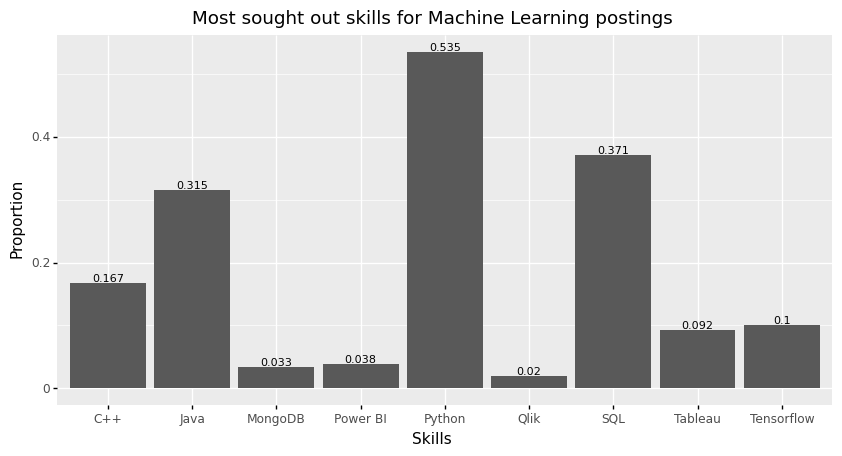

<ggplot: (8784630424971)>

In [26]:
p9.options.figure_size = (10, 4.8)
# Make the plot
plot = p9.ggplot(plot_df_prop)
plot += p9.geom_col(position='dodge')
plot += p9.aes(x= 'Skill', y = 'machine learning')
plot += p9.labs(title="Most sought out skills for Machine Learning postings",
             x="Skills",
             y="Proportion")
plot += p9.geom_text(p9.aes(label='machine learning'),size=8, va='bottom', format_string='{}')
plot

### Machine Learning Intern

For Machine Learning interns, the pattern is similar, with Python being the most crucial skill employers seek. C++, Python, and Tensorflow become slightly more common in these internships, when compared to their corresponding full job.

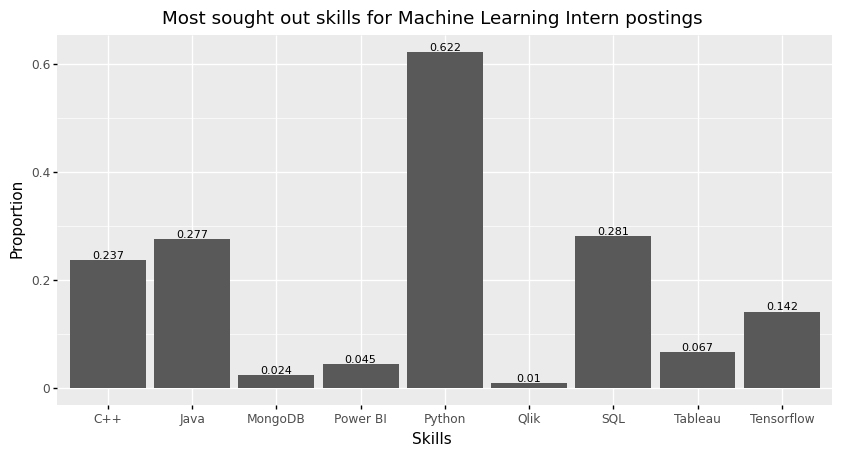

<ggplot: (8784630422357)>

In [27]:
p9.options.figure_size = (10, 4.8)
plot = p9.ggplot(plot_df_prop)
plot += p9.geom_col(position='dodge')
plot += p9.aes(x='Skill', y = 'machine learning intern')
plot += p9.labs(title="Most sought out skills for Machine Learning Intern postings",
             x="Skills",
             y="Proportion")
plot += p9.geom_text(p9.aes(label='machine learning intern'),size=8, va='bottom', format_string='{}')
plot

### Data Science

For Data Science job posts, it is not surprising to see that Python and SQL are the most sought out skills, but we also see an increase in Tableau compared to Machine Learning posts. There is less emphasis on Java & C++, which may be due to the simplicity and abundant data science packages/libraries that are present in Python. 

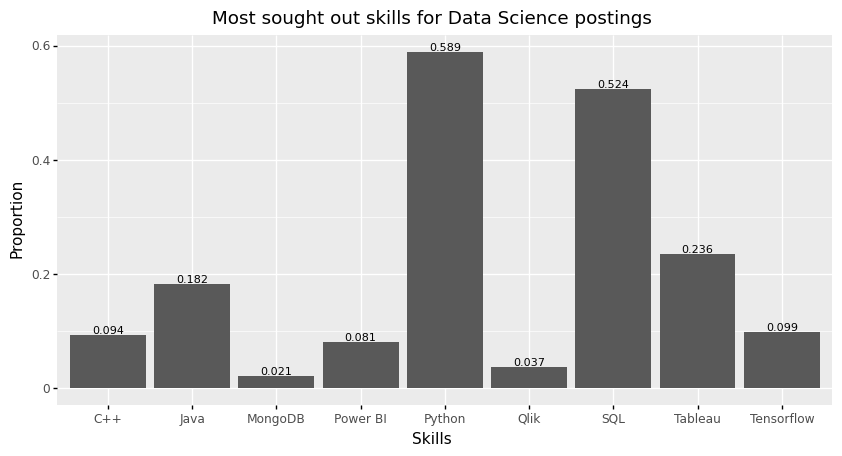

<ggplot: (8784630422279)>

In [28]:
p9.options.figure_size = (10, 4.8)
plot = p9.ggplot(plot_df_prop)
plot += p9.geom_col(position='dodge')
plot += p9.aes(x='Skill', y = 'data science')
plot += p9.labs(title="Most sought out skills for Data Science postings",
             x="Skills",
             y="Proportion")
plot += p9.geom_text(p9.aes(label='data science'),size=8, va='bottom', format_string='{}')
plot

### Data Science Intern

Overall, Data Science intern posts follow a similar trend with Data Science posts. The slight differences in the SQL and Tableau columns may be due to larger intern/full-time distinctions in this field. 

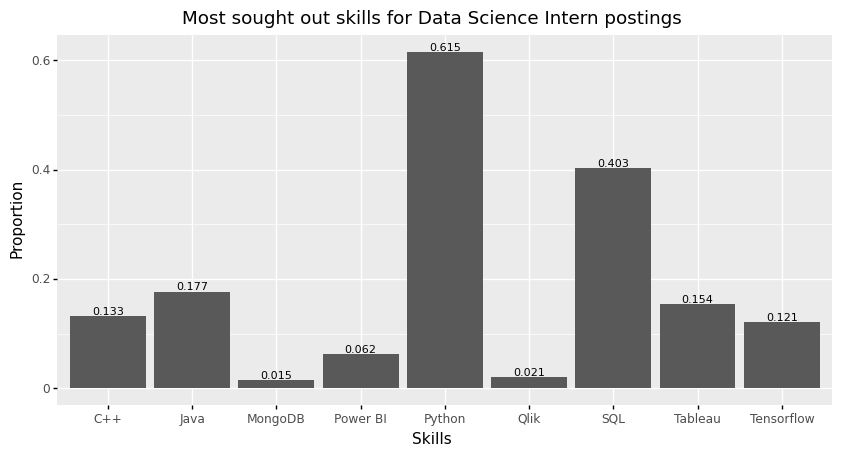

<ggplot: (8784630418764)>

In [29]:
p9.options.figure_size = (10, 4.8)
plot = p9.ggplot(plot_df_prop)
plot += p9.geom_col(position='dodge')
plot += p9.aes(x='Skill', y = 'data science intern')
plot += p9.labs(title="Most sought out skills for Data Science Intern postings",
             x="Skills",
             y="Proportion")
plot += p9.geom_text(p9.aes(label='data science intern'),size=8, va='bottom', format_string='{}')
plot

### Data Analyst

For Data Analysts' posts we can see a clear distinction in employers' sought out skills compared to Data Science and Machine Learning posts.  
With SQL being the largest proportion followed by Tableau, we can infer that, for a Data Analyst, they rarely have to learn programming languages such as Python to do their job because they do not come across data pipeline duties or machine learning methods. 
For example, we can see that Tensorflow, an open-source software library for machine learning, is almost never asked for among job postings.

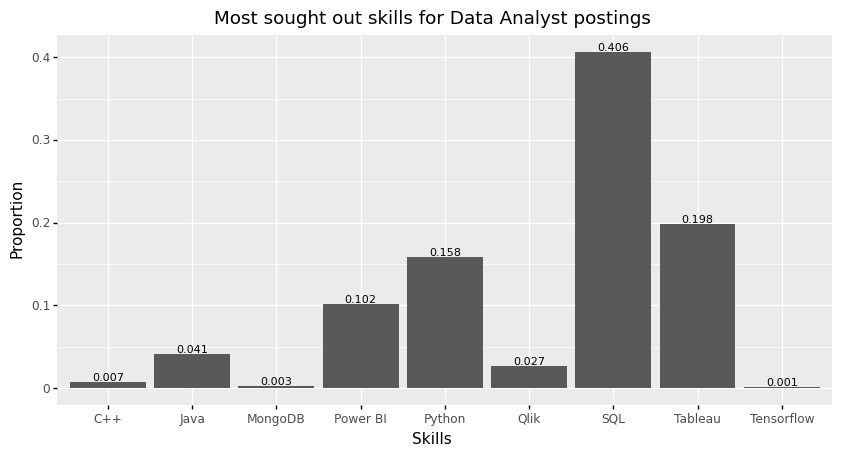

<ggplot: (8784631582085)>

In [30]:
p9.options.figure_size = (10, 4.8)
plot = p9.ggplot(plot_df_prop)
plot += p9.geom_col(position='dodge')
plot += p9.aes(x='Skill', y = 'data analyst')
plot += p9.labs(title="Most sought out skills for Data Analyst postings",
             x="Skills",
             y="Proportion")
plot += p9.geom_text(p9.aes(label='data analyst'),size=8, va='bottom', format_string='{}')
plot

### Data Analyst Intern

The Data Analyst intern positions closely follow their non-intern counterpart. The use of Python has increased, possibly due to these interns filling in for smaller data-related duties, like maintaining data pipelines.

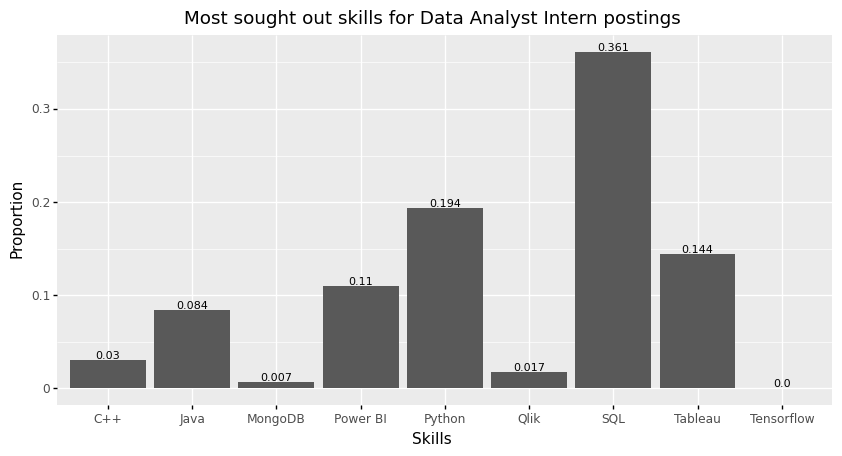

<ggplot: (8784632062868)>

In [31]:
p9.options.figure_size = (10, 4.8)
plot = p9.ggplot(plot_df_prop)
plot += p9.geom_col(position='dodge')
plot += p9.aes(x='Skill', y = 'data analyst intern')
plot += p9.labs(title="Most sought out skills for Data Analyst Intern postings",
             x="Skills",
             y="Proportion")
plot += p9.geom_text(p9.aes(label='data analyst intern'),size=8, va='bottom', format_string='{}')
plot

## Overall Plots

We use the following mapping to abbreviate the long query names, to clean up the following plots.  
`abbreviation = {'machine learning':"ML",'machine learning intern':"MLi", 'data science':"DS", 'data science intern':"DSi", 'data analyst':"DA", 'data analyst intern':"DAi"}`

In [32]:
## Munge/Transform the data, so that each row is one observation (with 2 indep. 
## variables, and 1 dependent variable)
plot_df_prop2 = pd.melt(plot_df_prop, id_vars=["Skill"], var_name = "Query", value_name = "Prop.")
#print(plot_df_prop2.head(3))

In [33]:
abbreviation = {'machine learning':"ML",
                'machine learning intern':"MLi", 
                'data science':"DS", 
                'data science intern':"DSi", 
                'data analyst':"DA", 
                'data analyst intern':"DAi"}
plot_df_prop2 = plot_df_prop2.replace({"Query": abbreviation})
plot_df_prop2.head()

,Skill,Query,Prop.
0,C++,ML,0.167
1,Java,ML,0.315
2,MongoDB,ML,0.033
3,Power BI,ML,0.038
4,Python,ML,0.535


We see that, for Machine Learning and Data Science, Python is a very important skill to have for prospective employees. 

Machine Learning postings have higher proportions of many programming languages such as C++, Java, and Python. 

On the other hand, Data Science postings primarily mention Python as the most important skill. 

We see that the proportions for the same programming languages are not as prominent in Data Analyst postings.

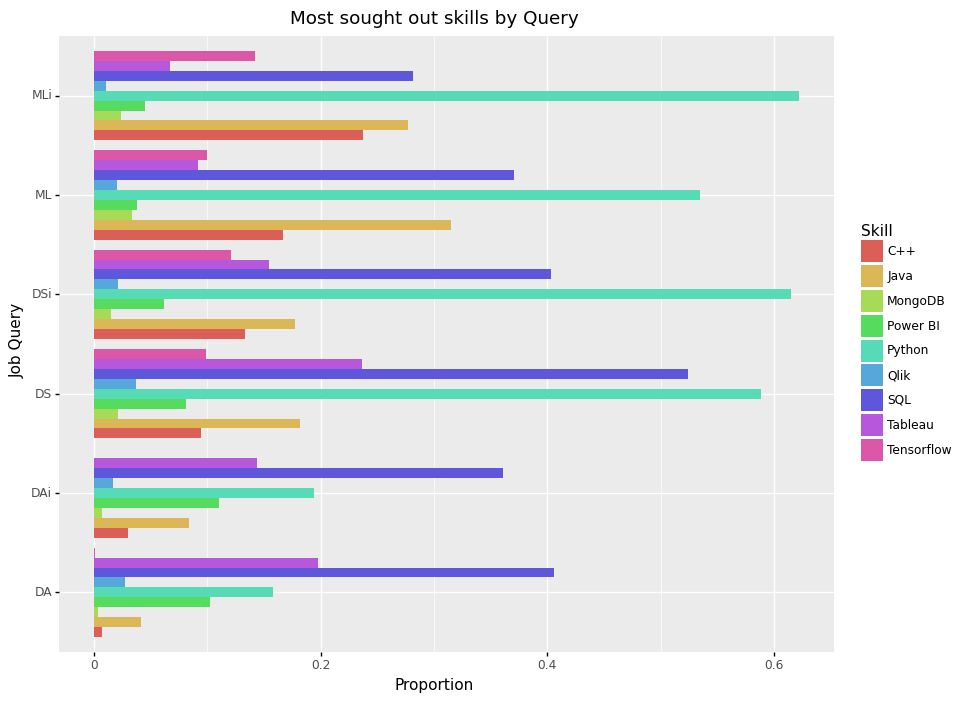

<ggplot: (8784632957067)>

In [34]:
p9.options.figure_size = (10, 8)
plot = p9.ggplot(plot_df_prop2)
plot += p9.geom_col(position='dodge')
plot += p9.aes(x='Query', y = 'Prop.', fill = "Skill")
plot += p9.labs(title="Most sought out skills by Query",
             x="Job Query",
             y="Proportion")
plot += p9.coord_flip()
plot

From this plot, we see that there is a slight, but clear, distinction between data analyst positions' skills and the skills required for other data jobs. 

SQL is equally important across all six queries, but Python is much less required for data analyst jobs. 

C++, Java, and Tensorflow are increasingly more common in data science and machine learning positions, respectively, while data analyst positions almost never ask for these skills by name.

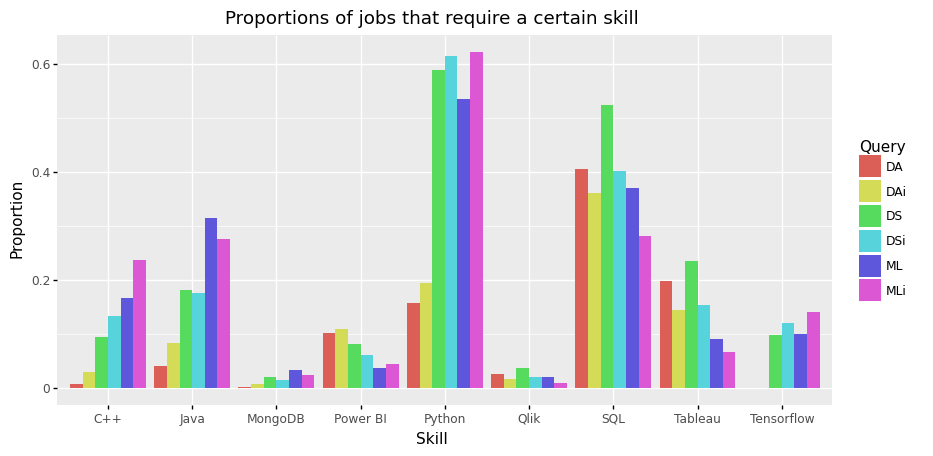

<ggplot: (8784632933310)>

In [35]:
p9.options.figure_size = (10, 4.8)
plot = p9.ggplot(plot_df_prop2)
plot += p9.geom_col(position='dodge')
plot += p9.aes(x='Skill', y = 'Prop.', fill = "Query")
plot += p9.labs(title="Proportions of jobs that require a certain skill",
             x="Skill",
             y="Proportion")
plot

# Statistical Tests: Chi-Squared

## Perform Chi-Squared Tests For Each Skill

\<options for analysis...>
<!--
Multiple contingency tables, each having many jobs & one skill:
- divide by the job: what % of each job requires/doesn't require this skill
```
| SQL | ML  | MLi | DS  | DSi | DA  | DAi |
|-----------------------------------------|
| Yes | .71 | .79 | .82 | ... | ... | ... |
| No  | .29 | .21 | .18 | ... | ... | ... |
And again for Tableau: 
| Tableau | ...
  ...       ...
```

**or**

A table of all skills AND all jobs, with each row being one skill: 
- but this won't add up to 100%, no chi-sq test?
-->

For each skill that we investigated, we determined whether its proportions of appearances differ among job types; i.e. whether different jobs are equally likely to ask for a specific skill. We calculated an overall proportion for each skill, to compare against. Then, we determined the residuals of each observation (proportion of occurrences per job query); we standardize, square, and take the sum of this residual to get the overall chi-square statistic. 

Comparing this statistic to the critical value will determine which hypothesis - $H_0$: all of the proportions are the same, or $H_a$: at least two of the proportions differ - is true. 

In [36]:
## Loop through the dataframe, calculate chi-sq. for each row
# https://www.thoughtco.com/critical-values-with-a-chi-square-table-3126426
for row in df.iterrows():
    skill = row[1][0]; print(skill+": ", end="\n")
    counts = row[1][1:]
    props = np.array(counts)/np.array(totals); print("Proportions: "+str(props))
    overall = sum(counts)/float(sum(totals)); #print(overall)
    numerator = (props - overall); #print(numerator)
    denominator = (overall*(1-overall)/np.array(totals))**0.5; #print(denominator)
    chisq_stat = sum((numerator/denominator)**2); print("Chi-Sq. Stat: "+str(chisq_stat), end="\n\n")
# df for chi-sq goodness of fit = (outcomes-1) = (2-1) = 1

C++: 
Proportions: [0.16675985462678222 0.23735955056179775 0.09362738465701528
 0.13305613305613306 0.007404181184668989 0.030100334448160536]
Chi-Sq. Stat: 1536.7705595941172

Java: 
Proportions: [0.3154878389712049 0.27668539325842695 0.18184278176160196
 0.17671517671517672 0.04050522648083624 0.08361204013377926]
Chi-Sq. Stat: 2248.5405257657712

MongoDB: 
Proportions: [0.03270897400055913 0.023876404494382022 0.021106751454471655
 0.014553014553014554 0.00272212543554007 0.006688963210702341]
Chi-Sq. Stat: 222.62802139624284

Power BI: 
Proportions: [0.03774112384679899 0.0449438202247191 0.0807739142199973
 0.062370062370062374 0.1019163763066202 0.11036789297658862]
Chi-Sq. Stat: 257.557298943674

Python: 
Proportions: [0.5346659211629857 0.6221910112359551 0.589230144770667
 0.6153846153846154 0.15810104529616725 0.1939799331103679]
Chi-Sq. Stat: 4112.4803747271635

Qlik: 
Proportions: [0.019849035504612804 0.009831460674157303 0.03734271411175754
 0.02079002079002079 0.026894

Because we were unsure of the true degrees of freedom, we determined the chi-square critical value with multiple possible degrees of freedom. We also used `np.random.chisquare()` to simulate a distribution that had a perfect degree of freedom for the data, as opposed to using a chi-square table, and used `np.quantile()` to determine the critical value. 

*I'm not sure how exactly to apply the Chi-Squared test in this situation, but the code above shouldn't be too far off - I get the error of each cell's proportion from the expected proportion, standardize and aggregate them into the Chi^2 statistic, and compare it to the (simulated) error statistics for the specific degrees of freedom.*

*For df, I've read in some sources that I should use (outcome levels - 1), but other sources seem to use (rows - 1)(columns - 1) because they're operating on contingency tables. It seems that, regardless of which chi-sq. critical value I am using, the outcome is that the proportions are statistically significant.*

*I will include a PDF excerpt from the statistics textbook I am basing my test on, which performs a chi-sq. test on three proportions that do not sum to 1.*

In [37]:
# Find the chi-sq. critical value for alpha = 0.05
r_chi=[]
for i in range(0, 30000):
    r_chi.append(np.random.chisquare(2-1))  # if it's outcome-1
len(r_chi)
print(np.quantile(r_chi, 0.95))

# https://en.wikipedia.org/wiki/Chi-squared_test
r_chi=[]
for i in range(0, 30000):
    r_chi.append(np.random.chisquare((2-1)*(6-1)))  # if it's (outcome-1)(predictor-1)
len(r_chi)
print(np.quantile(r_chi, 0.95))

r_chi=[]
for i in range(0, 30000):
    r_chi.append(np.random.chisquare((6-1)*(len(Query_list)-1)))  # if it's (rows-1)(columns-1) for the whole thing (unlikely)
len(r_chi)
print(np.quantile(r_chi, 0.95))

3.86120037804681
11.04960899511525
37.817746196315184


The chi-squared statistics obtained here are all greater than any possible critical value (due to the nature of the data, different degrees of freedom may be possible, although we cannot decide which is the correct one). **We can reject the null hypothesis $H_0$, and conclude that: for every skill investigated here, there are statistically significant differences between at least two of the proportions of job listings that mention that skill, across different job types.**

# Conclusion

In this project, we have confirmed that many different Big Data jobs have distinct and somewhat unique job requirements. Machine Learning jobs, and to some extent, Data Science jobs as well, have significantly more programming requirements than Data Analyst positions. Based on the visualizations we created, Data Analyst jobs have the strongest distinction between themselves and other fields, while the Machine Learning and Data Science industry seems to have some degree of overlap. Our chi-square tests also confirmed that the proportions of jobs that required any given skill were different at the significance level alpha = 0.05, and this even included skills that had the least representation, like Qlik (and Tensorflow). 